# Create a Time Series Anomaly Detection Model using Salesforce Merlion

1. Connect to CrateDB

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
from crate import client

# Before starting, silence a particular warning on recent versions of NumPy.
# TODO: Stop using `swapaxes`.
warnings.filterwarnings("ignore", message=r"'DataFrame.swapaxes' is deprecated", category=FutureWarning)


# Download the data from the Numenta Anomaly Benchmark
data = pd.read_csv("https://github.com/crate/cratedb-datasets/raw/main/timeseries/nab-machine-failure.csv")

# Connect to a self-managed CrateDB instance.
CRATEDB_HTTP_URL_DEFAULT = "http://crate@localhost:4200/"

# Connect to CrateDB Cloud.
# CRATEDB_HTTP_URL_DEFAULT = "https://<username>:<password>@<your-instance>.azure.cratedb.net:4200?ssl=true"

CRATEDB_HTTP_URL = os.getenv("CRATEDB_HTTP_URL", CRATEDB_HTTP_URL_DEFAULT)

conn = client.connect(CRATEDB_HTTP_URL)


2. Import data into CrateDB

In [ ]:
# Split the data into chunks of 1000 rows each for better insert performance
chunk_size = 1000
chunks = np.array_split(data, int(len(data)/chunk_size))

# Insert the data into CrateDB
with conn:
    cursor = conn.cursor()
    # Create the table if it doesn't exist
    cursor.execute("CREATE TABLE IF NOT EXISTS machine_data (timestamp TIMESTAMP, temperature DOUBLE);")
    # Insert the data in chunks
    for chunk in chunks:
        cursor.executemany("INSERT INTO machine_data (timestamp, temperature) VALUES (?, ?);", list(chunk.itertuples(index=False, name=None)))
    cursor.execute("REFRESH TABLE machine_data;")

3. Read back the dataset from CrateDB

   Also, prepare data to be used for the model training approach.

In [37]:
from crate import client

conn = client.connect(CRATEDB_HTTP_URL)

with conn:
    cursor = conn.cursor()
    cursor.execute("""SELECT 
     DATE_BIN('5 min'::INTERVAL, "timestamp", 0) AS timestamp,
     MAX(temperature) AS value
     FROM machine_data
     GROUP BY timestamp
     ORDER BY timestamp ASC;""")
    data = cursor.fetchall()

In [39]:
# Convert crate returned data to pandas DataFrame
time_series = pd.DataFrame([{'timestamp': pd.Timestamp.fromtimestamp(item[0] / 1000), 'value': item[1]} for item in data])
# Set the timestamp as the index
time_series = time_series.set_index('timestamp')


4. Plot the dataset using matplotlib

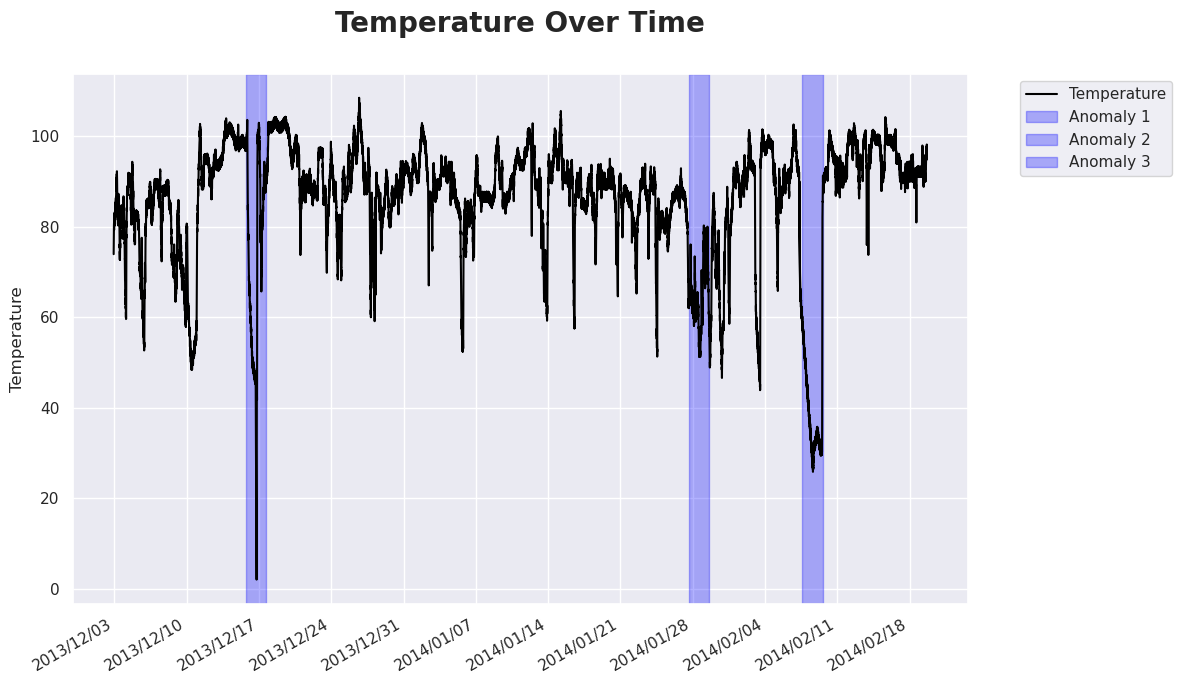

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

anomalies = [
    ["2013-12-15 17:50:00.000000", "2013-12-17 17:00:00.000000"],
    ["2014-01-27 14:20:00.000000", "2014-01-29 13:30:00.000000"],
    ["2014-02-07 14:55:00.000000", "2014-02-09 14:05:00.000000"]
]

plt.figure(figsize=(12,7))
line, = plt.plot(time_series.index, time_series['value'], linestyle='solid', color='black', label='Temperature')

# Highlight anomalies
ctr = 0
for timeframe in anomalies:
    ctr += 1
    plt.axvspan(pd.to_datetime(timeframe[0]), pd.to_datetime(timeframe[1]), color='blue', alpha=0.3, label=f'Anomaly {ctr}')

# Formatting x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))   
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  
plt.gcf().autofmt_xdate()  # Rotate & align the x labels for a better view

plt.title('Temperature Over Time', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Temperature')
# Add legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [56]:
from merlion.utils import TimeSeries

train_data = TimeSeries.from_pd(time_series[time_series.index < pd.to_datetime('2013-12-15')])
test_data = TimeSeries.from_pd(time_series[time_series.index >= pd.to_datetime('2013-12-15')])


4. Visualize the test/train split

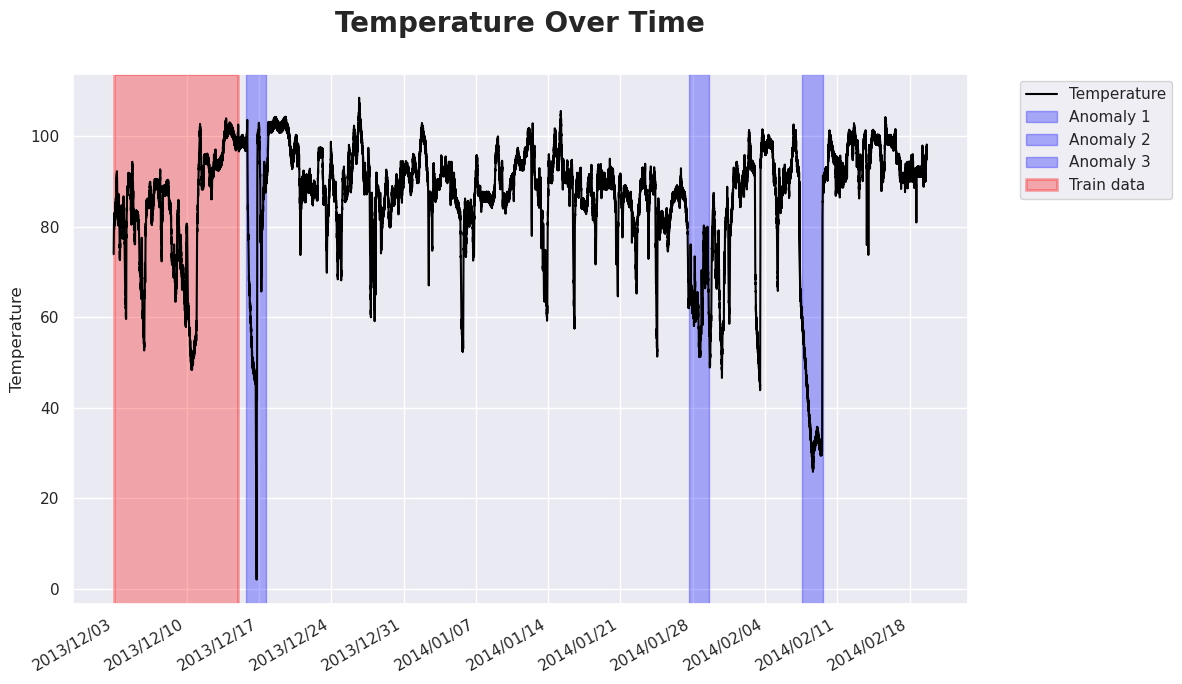

In [66]:
anomalies = [
    ["2013-12-15 17:50:00.000000", "2013-12-17 17:00:00.000000"],
    ["2014-01-27 14:20:00.000000", "2014-01-29 13:30:00.000000"],
    ["2014-02-07 14:55:00.000000", "2014-02-09 14:05:00.000000"]
]

plt.figure(figsize=(12,7))
line, = plt.plot(time_series.index, time_series['value'], linestyle='solid', color='black', label='Temperature')

# Highlight anomalies
ctr = 0
for timeframe in anomalies:
    ctr += 1
    plt.axvspan(pd.to_datetime(timeframe[0]), pd.to_datetime(timeframe[1]), color='blue', alpha=0.3, label=f'Anomaly {ctr}')

# Add vertical line for train/test split
plt.axvspan(pd.to_datetime('2013-12-03'), pd.to_datetime('2013-12-15'), color='red', alpha=0.3, linewidth=2, label="Train data")

# Formatting x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))   
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  
plt.gcf().autofmt_xdate()  # Rotate & align the x labels for a better view

plt.title('Temperature Over Time', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Temperature')
# Add legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

5. Training the model

In [86]:
%%capture
from merlion.models.defaults import DefaultDetectorConfig, DefaultDetector
model = DefaultDetector(DefaultDetectorConfig())
model.train(train_data=train_data)


In [87]:
test_pred = model.get_anomaly_label(time_series=test_data)
test = test_pred.to_pd()
test[test["anom_score"] > 0]

,anom_score
time,
2013-12-16 20:05:00,3.153673
2014-02-03 13:15:00,3.209799
2014-02-09 13:10:00,3.260402


time
2013-12-15 00:00:00    0.0
2013-12-15 00:05:00    0.0
2013-12-15 00:10:00    0.0
2013-12-15 00:15:00    0.0
2013-12-15 00:20:00    0.0
                      ... 
2014-02-19 16:05:00    0.0
2014-02-19 16:10:00    0.0
2014-02-19 16:15:00    0.0
2014-02-19 16:20:00    0.0
2014-02-19 16:25:00    0.0
Freq: 5T, Name: anom_score, Length: 19206, dtype: float64

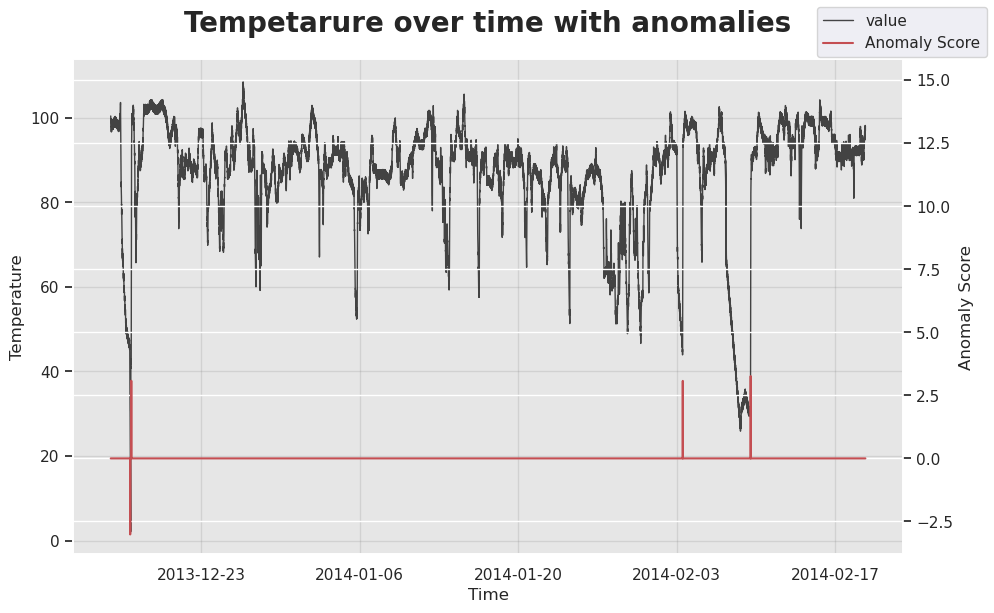

In [126]:
import matplotlib.pyplot as plt
fig, ax = model.plot_anomaly(time_series=test_data, filter_scores = True)
# Change the title
ax.set_title('Temperature over time with anomalies', fontsize=20, fontweight='bold', pad=20)
ax.set_ylabel('Temperature')

# Show the plot
plt.show()
